# Artigo de Pós-Graduação PUCRS

### Machine Learning.

In [1]:
import pandas as pd
import datetime
import glob
from minio import Minio
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from pycaret.classification import *

In [2]:
client = Minio(
        "localhost:9000",
        access_key="minioadmin",
        secret_key="minioadmin",
        secure=False
    )

### Baixando o Dataset do Data Lake.

In [3]:
client.fget_object(
            "processing",
            "employeesDataset.parquet",
            "temp_.parquet",
)
df = pd.read_parquet("temp_.parquet")
df = df[['Department', 'DaysLateLast30', 'Absences',
       'EmpSatisfaction', 'EngagementSurvey', 'PerformanceScore',
       'Termd']]

client.fget_object(
            "processing",
            "departmentSalaryTermd.parquet",
            "temp_.parquet",
)
dfSalary = pd.read_parquet("temp_.parquet")
dfSalary = dfSalary[['SalaryLevel']]

client.fget_object(
            "processing",
            "timeInCompany.parquet",
            "temp_.parquet",
)
dftimeInCompany = pd.read_parquet("temp_.parquet")
dftimeInCompany = dftimeInCompany[['TimeInCompany']]

client.fget_object(
            "processing",
            "numberSpecialProjects.parquet",
            "temp_.parquet",
)
dfNumberSpecialProjects = pd.read_parquet("temp_.parquet")
dfNumberSpecialProjects = dfNumberSpecialProjects[['SpecialProjectsCount']]

client.fget_object(
            "processing",
            "employeePerformanceEvaluation.parquet",
            "temp_.parquet",
)
dfPerfScoreFullyMeets = pd.read_parquet("temp_.parquet")
dfPerfScoreFullyMeets = dfPerfScoreFullyMeets[['perfScoreSatisfaction']]


df = pd.concat([df, dfSalary, dftimeInCompany, dfNumberSpecialProjects, dfPerfScoreFullyMeets], axis=1, join="inner")
df


,Department,DaysLateLast30,Absences,EmpSatisfaction,EngagementSurvey,PerformanceScore,Termd,SalaryLevel,TimeInCompany,SpecialProjectsCount,perfScoreSatisfaction
0,Production,0,1,5,4.60,Exceeds,0,medium,8,0,False
1,IT/IS,0,17,3,4.96,Fully Meets,1,high,2,6,False
2,Production,0,3,3,3.02,Fully Meets,1,medium,2,0,False
3,Production,0,15,5,4.84,Fully Meets,0,medium,11,0,True
4,Production,0,2,4,5.00,Fully Meets,1,low,6,0,False
...,...,...,...,...,...,...,...,...,...,...,...
306,Production,0,13,4,4.07,Fully Meets,0,medium,5,0,True
307,Production,5,4,2,3.20,PIP,1,low,8,0,False
308,IT/IS,0,16,5,4.60,Exceeds,0,high,9,6,False
309,IT/IS,0,11,3,5.00,Fully Meets,0,high,4,5,True


In [4]:
df.groupby(["perfScoreSatisfaction"])["perfScoreSatisfaction"].count()

perfScoreSatisfaction
False    143
True     168
Name: perfScoreSatisfaction, dtype: int64

#### Verificando os registros missing.

In [5]:
df.isnull().sum()

Department               0
DaysLateLast30           0
Absences                 0
EmpSatisfaction          0
EngagementSurvey         0
PerformanceScore         0
Termd                    0
SalaryLevel              0
TimeInCompany            0
SpecialProjectsCount     0
perfScoreSatisfaction    0
dtype: int64

In [6]:
df[df.notnull()]

,Department,DaysLateLast30,Absences,EmpSatisfaction,EngagementSurvey,PerformanceScore,Termd,SalaryLevel,TimeInCompany,SpecialProjectsCount,perfScoreSatisfaction
0,Production,0,1,5,4.60,Exceeds,0,medium,8,0,False
1,IT/IS,0,17,3,4.96,Fully Meets,1,high,2,6,False
2,Production,0,3,3,3.02,Fully Meets,1,medium,2,0,False
3,Production,0,15,5,4.84,Fully Meets,0,medium,11,0,True
4,Production,0,2,4,5.00,Fully Meets,1,low,6,0,False
...,...,...,...,...,...,...,...,...,...,...,...
306,Production,0,13,4,4.07,Fully Meets,0,medium,5,0,True
307,Production,5,4,2,3.20,PIP,1,low,8,0,False
308,IT/IS,0,16,5,4.60,Exceeds,0,high,9,6,False
309,IT/IS,0,11,3,5.00,Fully Meets,0,high,4,5,True


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Department             311 non-null    object 
 1   DaysLateLast30         311 non-null    int64  
 2   Absences               311 non-null    int64  
 3   EmpSatisfaction        311 non-null    int64  
 4   EngagementSurvey       311 non-null    float64
 5   PerformanceScore       311 non-null    object 
 6   Termd                  311 non-null    int64  
 7   SalaryLevel            311 non-null    object 
 8   TimeInCompany          311 non-null    int64  
 9   SpecialProjectsCount   311 non-null    int64  
 10  perfScoreSatisfaction  311 non-null    bool   
dtypes: bool(1), float64(1), int64(6), object(3)
memory usage: 24.7+ KB


###  Importancia de Features

In [8]:
df.head()

,Department,DaysLateLast30,Absences,EmpSatisfaction,EngagementSurvey,PerformanceScore,Termd,SalaryLevel,TimeInCompany,SpecialProjectsCount,perfScoreSatisfaction
0,Production,0,1,5,4.60,Exceeds,0,medium,8,0,False
1,IT/IS,0,17,3,4.96,Fully Meets,1,high,2,6,False
2,Production,0,3,3,3.02,Fully Meets,1,medium,2,0,False
3,Production,0,15,5,4.84,Fully Meets,0,medium,11,0,True
4,Production,0,2,4,5.00,Fully Meets,1,low,6,0,False


vamos desenvolver um modelo que use a classe perfScoreSatisfaction que posie valor do tipo discreto, onde sabemos se o funcionário está satisfeito com a empresa e é engajado, nos conduz a um problema do tipo classificação supervisionada. Ou seja, tempos um atributo para passar para o modelo.


# Preprocessamento de dados

#### Converte os atributos categoricos em númericos.

Aplicamos uma tecnica simples de transformação dos dados, transformando dados categoricos em numericos por duas razoes: A maioria dos modelos que usamos em ciências de dados tem como entrada valores numericos, não sendo preparados para trabalhar com valores catégoricos; Os atributos categoricos tem pouca cardinalidade, tendo poucos registros unicos

In [9]:
df["Department"] = df["Department"].astype('category').cat.codes
df["SalaryLevel"] = df["SalaryLevel"].astype('category').cat.codes
df["PerformanceScore"] = df["PerformanceScore"].astype('category').cat.codes
df["perfScoreSatisfaction"] = df["perfScoreSatisfaction"].astype('category').cat.codes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Department             311 non-null    int8   
 1   DaysLateLast30         311 non-null    int64  
 2   Absences               311 non-null    int64  
 3   EmpSatisfaction        311 non-null    int64  
 4   EngagementSurvey       311 non-null    float64
 5   PerformanceScore       311 non-null    int8   
 6   Termd                  311 non-null    int64  
 7   SalaryLevel            311 non-null    int8   
 8   TimeInCompany          311 non-null    int64  
 9   SpecialProjectsCount   311 non-null    int64  
 10  perfScoreSatisfaction  311 non-null    int8   
dtypes: float64(1), int64(6), int8(4)
memory usage: 18.3 KB


In [10]:
df.head()

,Department,DaysLateLast30,Absences,EmpSatisfaction,EngagementSurvey,PerformanceScore,Termd,SalaryLevel,TimeInCompany,SpecialProjectsCount,perfScoreSatisfaction
0,3,0,1,5,4.60,0,0,2,8,0,0
1,2,0,17,3,4.96,1,1,0,2,6,0
2,3,0,3,3,3.02,1,1,2,2,0,0
3,3,0,15,5,4.84,1,0,2,11,0,1
4,3,0,2,4,5.00,1,1,1,6,0,0


#### Separando os conjuntos de dados.

In [11]:
#perfScoreSatisfaction
targetName = 'perfScoreSatisfaction'
X = df.drop('perfScoreSatisfaction', axis=1)
y = df[targetName]

#### Transformando os dados.
Vamos transformar os valores dos atibutos em uma mesma escala. Uma vez que temos varios atributos em diferentes escalas, com o MimMaxScaler do sklearn vamos garantir a mesma escala para os atributos.

Isso é importante no processo de convergencia do algoritmo, nos calculos internos que o algoritmo faz para gerar o modelo os calculos de valores na mesma escala ajuda o medelo a ter uma peformace melhor, a convergir com mais velocidade, principalmente em cenários complexo como nos uso de deep learning. 

In [12]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X

array([[0.6       , 0.        , 0.        , ..., 1.        , 0.58333333,
        0.        ],
       [0.4       , 0.        , 0.84210526, ..., 0.        , 0.08333333,
        0.75      ],
       [0.6       , 0.        , 0.10526316, ..., 1.        , 0.08333333,
        0.        ],
       ...,
       [0.4       , 0.        , 0.78947368, ..., 0.        , 0.66666667,
        0.75      ],
       [0.4       , 0.        , 0.52631579, ..., 0.        , 0.25      ,
        0.625     ],
       [0.6       , 0.        , 0.05263158, ..., 0.5       , 0.33333333,
        0.        ]])

#### Separando os conjuntos.

Definindo nosso modelo como preditivo e para dar uma garantia que o modelo é integro, é importante particionar os dados em dois conjunto, um para treinar e outro para testar o modelo

Apesar do dataset ter a classe target perfScoreSatisfaction muito balanceada, o dataset tambem tem outras classes desbalanceadas. Respeitando a distribuição de classes com uma amostra que reúne clases mais ou menos homogêneas entre si, usamos o parametro stratify.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
        X
       ,y
       ,test_size = 0.3
       ,random_state = 33
       ,stratify = y
)

#### Treinando o algoritmo de arvore de decisão.

In [14]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train,y_train)

importances = dtree.feature_importances_
feat_names = df.drop(['perfScoreSatisfaction'],axis=1).columns

filtragem de features importantes mara o modelo escolhi usar as funcionalidades de feature_importances_ dos classificadores. Treinamos o modelos e verificamos quais as feactures mais importantes para o modelo criado, que por sua vez retorna uma listagem de features importantes.
Em ambiente de produção é necessário mais experimentos com outros algoritmos para selecionar as features importantes

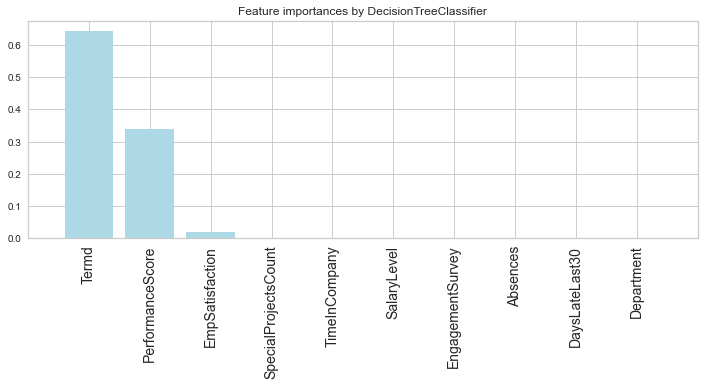

In [15]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,4))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

Com modelo de arvore de decisão as features mais relevantes são Termd e PerfomanceScore com uma indicação pequena para EmpSatisfaction

#### Filtrando apenas os atributos relevantes.

In [16]:
df.columns

Index(['Department', 'DaysLateLast30', 'Absences', 'EmpSatisfaction',
       'EngagementSurvey', 'PerformanceScore', 'Termd', 'SalaryLevel',
       'TimeInCompany', 'SpecialProjectsCount', 'perfScoreSatisfaction'],
      dtype='object')

In [17]:
X = df[["Termd","PerformanceScore","EmpSatisfaction"]]

#### Separando os conjuntos de dados.

In [18]:
X = df[['DaysLateLast30', 'Absences', 'EmpSatisfaction',
       'EngagementSurvey', 'PerformanceScore', 'Termd', 'SalaryLevel',
       'TimeInCompany', 'SpecialProjectsCount', 'perfScoreSatisfaction']]

In [19]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
        X
       ,y
       ,test_size = 0.2
       ,random_state = 123
       ,stratify = y
)

X_train

array([[0.        , 1.        , 1.        , ..., 0.16666667, 0.        ,
        0.        ],
       [0.        , 0.47368421, 0.75      , ..., 0.        , 0.5       ,
        0.        ],
       [0.        , 0.78947368, 0.5       , ..., 0.16666667, 0.        ,
        0.        ],
       ...,
       [0.33333333, 0.21052632, 0.        , ..., 0.33333333, 0.        ,
        0.        ],
       [0.        , 0.68421053, 0.75      , ..., 0.41666667, 0.        ,
        0.        ],
       [0.        , 0.21052632, 0.75      , ..., 0.16666667, 0.        ,
        0.        ]])

#### Função do modelo de base.

Pensando na satisfação e engajamento do funcionario, vamos preparar testes para features relevantes para outros algoritmos.

Para isso estabelecer qual a metrica, o que levar em consideração para decidir se o algoritmo é eficiente.

Começamos criando um modelo base line para que os modelos a serem esperimentados cheguem proximos do resultado do base line. Se ele não tiver com os resultados proximos da baseline, não faz sentido investir tempo nesse modelo. Além disso, a função da baseline é importante para conseguir explicar o resultado do modelo de forma intuitiva para pessoas que não entende ML. Por exemplo, gerei um modelo de previsão de engajamento e satisfação que é superior a média, a média chegamos no resultado x enquanto que nosso modelo atingiu x+y. Os interessados conseguem entender que o modelo ganha de algo simples que já é usado, como a média.

por causa dos dados despalenceados, essa função sempre vai retornar zero para a probabilidade da maior ocorrencia do meu conjunto de dados


In [20]:
def baseRateModel(X) :
    y = np.ones(X.shape[0])
    return y

In [21]:
X_test.shape[0]

63

#### Importando métodos de métrica de avaliação.

curva roc, acuracia e 

In [22]:
def accuracyResult(y_test,y_predict):
    acc = accuracy_score(y_test, y_predict)
    print ("Accuracy = %2.2f" % acc)

In [23]:
def rocClassificationReportResults(model,y_test,y_predict):
    roc_ = roc_auc_score(y_test, y_predict)
    classfication_report = classification_report(y_test, y_predict)
    
    print ("\n{} AUC = {}\n".format(model, roc_))
    print(classfication_report)

#### Análise do modelo de baseline

In [24]:
y_predict = baseRateModel(X_test)

In [25]:
rocClassificationReportResults("Base Model", y_test, y_predict)


Base Model AUC = 0.5

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.54      1.00      0.70        34

    accuracy                           0.54        63
   macro avg       0.27      0.50      0.35        63
weighted avg       0.29      0.54      0.38        63



- Acuracia de 0.54, o baseline não acertou muito ou só acertou somente os funcionários satisfeitos e engajados.
- O classification reporte detalha mais mais confirmando que o modelo baseline realmente não está tão bem.
- Para a classe 1 o baseline tem uma precisão de 54% que é exatamente a probabilidade de funcionários engajados e satisfeitos na empresa.
- A clase 0, nao acertou nada.
- A baseline só acerta a classe 1
- O Base Model AUC deu 50%, pois só acerta uma das duas classes. A area sobre a curva considera todas as classes

In [26]:
rocClassificationReportResults("Base Model", y_test, y_predict)


Base Model AUC = 0.5

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.54      1.00      0.70        34

    accuracy                           0.54        63
   macro avg       0.27      0.50      0.35        63
weighted avg       0.29      0.54      0.38        63



In [27]:
print("Test Result:")
print("------------")
print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_predict)))
print("accuracy score: {0:.2f}\n".format(accuracy_score(y_test, y_predict)))

Test Result:
------------
Confusion Matrix: 
 [[ 0 29]
 [ 0 34]]

accuracy score: 0.54



### Modelo de Regressão Logística.

#### Instânciando o algoritmo.

In [28]:
logis = LogisticRegression()

#### Realizando o treinamento.

In [29]:
logis.fit(X_train, y_train)

LogisticRegression()

#### Calculando as predições.

In [30]:
y_predict = logis.predict(X_test)

#### Avaliando o resultado.

In [31]:
print("Train Result:")
print("------------")
print("Classification Report: \n {}\n".format(classification_report(y_train, logis.predict(X_train))))

print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, logis.predict(X_train))))

res = cross_val_score(logis, X_train, y_train, cv=10, scoring='accuracy')

print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
print("----------------------------------------------------------")

Train Result:
------------
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       1.00      1.00      1.00       134

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248


Confusion Matrix: 
 [[114   0]
 [  0 134]]

Average Accuracy: 	 1.0000
Accuracy SD: 		 0.0000
----------------------------------------------------------


- acuracia superior a do baseline semelhante a Logistic Regression AUC = 0.88
- para classe 0 o modelo de regressão logistica acerta 100% enquanto que para classe 1 acerta 83% o que parece ser um bom resultado

In [32]:
rocClassificationReportResults("Logistic Regression", y_test, y_predict)


Logistic Regression AUC = 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        34

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



In [33]:
print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_predict)))
print("accuracy score: {0:.2f}\n".format(accuracy_score(y_test, y_predict)))

Confusion Matrix: 
 [[29  0]
 [ 0 34]]

accuracy score: 1.00



### Modelo de Arvore de decisão.

#### Instânciando o algoritmo.

In [34]:
dtree = DecisionTreeClassifier()

#### Realizando o treinamento.

In [35]:
dtree = dtree.fit(X_train,y_train)

#### Calculando as predições.

In [36]:
y_predict = dtree.predict(X_test)

#### Avaliando o resultado.

In [37]:
print("Train Result:")
print("------------")
print("Classification Report: \n {}\n".format(classification_report(y_train, dtree.predict(X_train))))

print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, dtree.predict(X_train))))

res = cross_val_score(dtree, X_train, y_train, cv=10, scoring='accuracy')

print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
print("----------------------------------------------------------")

Train Result:
------------
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       1.00      1.00      1.00       134

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248


Confusion Matrix: 
 [[114   0]
 [  0 134]]

Average Accuracy: 	 1.0000
Accuracy SD: 		 0.0000
----------------------------------------------------------


- A arvore de decisão deu acuracia maior
- Decision Tree AUC = 1.00
- Aumentou a precisao da classe 1 comparado com os modelos anteriores

In [38]:
rocClassificationReportResults("Decision Tree", y_test, y_predict)


Decision Tree AUC = 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        34

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



In [39]:
print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_predict)))
print("accuracy score: {0:.2f}\n".format(accuracy_score(y_test, y_predict)))

Confusion Matrix: 
 [[29  0]
 [ 0 34]]

accuracy score: 1.00



### Modelo de Arvore Aleatória (Random Forest)

#### Instânciando o algoritmo.

In [40]:
rf = RandomForestClassifier()

#### Realizando o treinamento.

In [41]:
rf = rf.fit(X_train,y_train)

#### Calculando as predições.

In [42]:
y_predict = rf.predict(X_test)

#### Avaliando o resultado.

In [43]:
print("Train Result:")
print("------------")
print("Classification Report: \n {}\n".format(classification_report(y_train, rf.predict(X_train))))

print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, rf.predict(X_train))))

res = cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy')

print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
print("----------------------------------------------------------")

Train Result:
------------
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       1.00      1.00      1.00       134

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248


Confusion Matrix: 
 [[114   0]
 [  0 134]]

Average Accuracy: 	 1.0000
Accuracy SD: 		 0.0000
----------------------------------------------------------


- O modelo de Floresta aleatória alcançou 100% de acuracia para as duas classes


In [44]:
rocClassificationReportResults("Random Forest", y_test, y_predict)


Random Forest AUC = 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        34

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



In [45]:
print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_predict)))
print("accuracy score: {0:.2f}\n".format(accuracy_score(y_test, y_predict)))

Confusion Matrix: 
 [[29  0]
 [ 0 34]]

accuracy score: 1.00



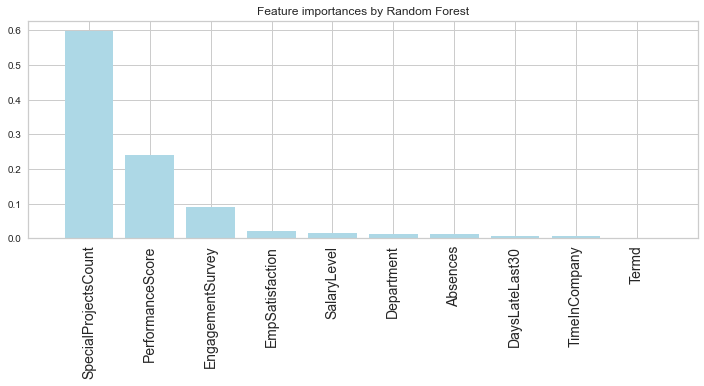

In [67]:
importances = rf.feature_importances_
feat_names = df.drop(['perfScoreSatisfaction'],axis=1).columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,4))
plt.title("Feature importances by Random Forest")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

para fins de experimentação usei a biblioteca pycaret, de forma a simplificar o pipeline de machinelearning do projeto e comparar resultados obtidos

### Pycaret

In [47]:
s = setup( df[['Department', 'DaysLateLast30', 'Absences', 'EmpSatisfaction',
       'EngagementSurvey', 'PerformanceScore', 'Termd', 'SalaryLevel',
       'TimeInCompany', 'SpecialProjectsCount', 'perfScoreSatisfaction']]
          ,target = 'perfScoreSatisfaction'
          ,numeric_features = ['TimeInCompany', 'DaysLateLast30', 'Absences','EngagementSurvey', 'EmpSatisfaction', 'PerformanceScore', 'SpecialProjectsCount']
          ,normalize = True
          ,normalize_method = "minmax"
          ,data_split_stratify = True
          ,fix_imbalance = True,
         )

,Description,Value
0,Session id,1228
1,Target,perfScoreSatisfaction
2,Target type,Binary
3,Original data shape,"(311, 11)"
4,Transformed data shape,"(328, 11)"
5,Transformed train set shape,"(234, 11)"
6,Transformed test set shape,"(94, 11)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


#### Comparando diferentes modelos.

In [48]:
best = compare_models(fold = 5,sort = 'AUC',)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0200
ada,Ada Boost Classifier,0.9909,1.0000,1.0000,0.9840,0.9918,0.9816,0.9820,0.0240
gbc,Gradient Boosting Classifier,0.9955,1.0000,1.0000,0.9920,0.9959,0.9908,0.9910,0.0200
et,Extra Trees Classifier,0.9862,1.0000,1.0000,0.9753,0.9874,0.9720,0.9727,0.0300
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0180
rf,Random Forest Classifier,0.9862,0.9996,1.0000,0.9753,0.9874,0.9720,0.9727,0.0400
nb,Naive Bayes,0.8846,0.9823,0.9656,0.8457,0.9005,0.7647,0.7778,0.1680
lda,Linear Discriminant Analysis,0.9215,0.9703,0.9739,0.8911,0.9302,0.8408,0.8466,0.0100
knn,K Neighbors Classifier,0.9216,0.9477,0.9917,0.8826,0.9326,0.8400,0.8517,0.1740
lr,Logistic Regression,0.8755,0.9473,1.0000,0.8150,0.8973,0.7441,0.7711,0.7220


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

- Ada Boost Classifier e Light Gradient Boosting Machine são capeoes nos resultados das metricas

#### Criando o modelo.

In [49]:
lightgbm = create_model('lightgbm', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Mean,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Std,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

#### Realizando o tunning do modelo.

In [50]:
tunedLightgbm = tune_model(lightgbm 
                      ,fold = 5
                      ,custom_grid = {"learning_rate":[0.1,0.2,0.5]
                                     ,"n_estimators":[100,500,1000]
                                     ,"min_samples_split":[1,2,5,10]
                                     ,"max_depth":[1,3,9]
                                     }
                      ,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9773,1.0000,1.0000,0.9600,0.9796,0.9540,0.9550
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Mean,0.9955,1.0000,1.0000,0.9920,0.9959,0.9908,0.9910
Std,0.0091,0.0000,0.0000,0.0160,0.0082,0.0184,0.0180


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] 

In [51]:
predict_model(lightgbm, data=df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,Department,DaysLateLast30,Absences,EmpSatisfaction,EngagementSurvey,PerformanceScore,Termd,SalaryLevel,TimeInCompany,SpecialProjectsCount,perfScoreSatisfaction,Label,Score
0,0.6,0.000000,0.000000,1.000000,0.896907,0.000000,0.0,1.0,0.583333,0.000,0,0,1.0000
1,0.4,0.000000,0.842105,0.333333,0.989691,0.333333,1.0,0.0,0.083333,0.750,0,0,1.0000
2,0.6,0.000000,0.105263,0.333333,0.489691,0.333333,1.0,1.0,0.083333,0.000,0,0,1.0000
3,0.6,0.000000,0.736842,1.000000,0.958763,0.333333,0.0,1.0,0.833333,0.000,1,1,0.9999
4,0.6,0.000000,0.052632,0.666667,1.000000,0.333333,1.0,0.5,0.416667,0.000,0,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,0.6,0.000000,0.631579,0.666667,0.760309,0.333333,0.0,1.0,0.333333,0.000,1,1,1.0000
307,0.6,0.833333,0.157895,0.000000,0.536083,1.000000,1.0,0.5,0.583333,0.000,0,0,1.0000
308,0.4,0.000000,0.789474,1.000000,0.896907,0.000000,0.0,0.0,0.666667,0.750,0,0,1.0000
309,0.4,0.000000,0.526316,0.333333,1.000000,0.333333,0.0,0.0,0.250000,0.625,1,1,1.0000


#### Finalizando o modelo de predição e disponibilizando para um eventual ambiente de produção.

In [52]:
finalModel = finalize_model(rf)
save_model(finalModel,'model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/var/folders/mj/jgp1syh15f353pj12fcfnzyc0000gn/T/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['TimeInCompany', 'DaysLateLast30',
                                              'Absences', 'EngagementSurvey',
                                              'EmpSatisfaction',
                                              'PerformanceScore',
                                              'SpecialProjectsCount'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=N...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='

#### Transferindo os arquivos para o Data Lake.

#### Modelo de Classificação.

In [53]:
client.fput_object(
    "curated",
    "model.pkl",
    "model.pkl"
)

#### Exportando o conjunto de dados para o disco.

In [54]:
df.to_csv("dataset.csv",index=False)

In [55]:
client.fput_object(
    "curated",
    "dataset.csv",
    "dataset.csv"
)

# Testar modelo

#### Modelo de classificacao,dataset e cluster.

In [56]:
client.fget_object("curated","model.pkl","model.pkl")
client.fget_object("curated","dataset.csv","dataset.csv")
client.fget_object("curated","cluster.joblib","cluster.joblib")

var_model = "model"
var_model_cluster = "cluster.joblib"
var_dataset = "dataset.csv"

#### Carregando o modelo treinado.

In [57]:
model = load_model(var_model)
model_cluster = joblib.load(var_model_cluster)

Transformation Pipeline and Model Successfully Loaded


#### Carregando o conjunto de dados.

In [58]:
dataset = pd.read_csv(var_dataset)
dataset.head()

,Department,DaysLateLast30,Absences,EmpSatisfaction,EngagementSurvey,PerformanceScore,Termd,SalaryLevel,TimeInCompany,SpecialProjectsCount,perfScoreSatisfaction
0,3,0,1,5,4.60,0,0,2,8,0,0
1,2,0,17,3,4.96,1,1,0,2,6,0
2,3,0,3,3,3.02,1,1,2,2,0,0
3,3,0,15,5,4.84,1,0,2,11,0,1
4,3,0,2,4,5.00,1,1,1,6,0,0


#### Grupos de funcionarios.

In [59]:
kmeans_colors = ['red' if c == 0 else 'blue' for c in model_cluster.labels_]

#### Mapeando dados do usuário para cada atributo

In [60]:
department = 3
daysLateLast30 = 3
absences = 3
empSatisfaction = 5
engagementSurvey = 4
performanceScore =4
termd = 0
salaryLevel = 4
timeInCompany = 6
specialProjectsCount = 4
perfScoreSatisfaction = 5

In [61]:
data_teste = pd.DataFrame()
data_teste['Department'] = [department]
data_teste['DaysLateLast30'] = [daysLateLast30]
data_teste['Absences'] = [absences]
data_teste['EmpSatisfaction'] = [empSatisfaction]
data_teste['EngagementSurvey'] = [engagementSurvey]
data_teste['PerformanceScore'] = [performanceScore]
data_teste['Termd'] = [termd]
data_teste['SalaryLevel'] = [salaryLevel]
data_teste['TimeInCompany'] = [timeInCompany]
data_teste['SpecialProjectsCount'] = [specialProjectsCount]
data_teste['perfScoreSatisfaction'] = [perfScoreSatisfaction]

## Realiza a predição do modelo

In [62]:
result = predict_model(model, data=data_teste)
result

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000


,Department,DaysLateLast30,Absences,EmpSatisfaction,EngagementSurvey,PerformanceScore,Termd,SalaryLevel,TimeInCompany,SpecialProjectsCount,perfScoreSatisfaction,Label,Score
0,0.6,0.5,0.105263,1.0,0.742268,1.333333,0.0,2.0,0.416667,0.5,5,1,0.54


#### Resultados

In [63]:
classe = result['Label'][0]
probabilidade = result['Score'][0]*100

In [64]:
if classe == 1:
    print(f'A predição do modelo para a amostra de teste é de funcionário satisfeito e engajado com probabilidade de: {probabilidade:.2f}%')
else:
    print(f'A predição do modelo para a amostra de teste é de funcionário não satisfeito e não engajado com probabilidade de: {probabilidade:.2f}%')

A predição do modelo para a amostra de teste é de funcionário satisfeito e engajado com probabilidade de: 54.00%


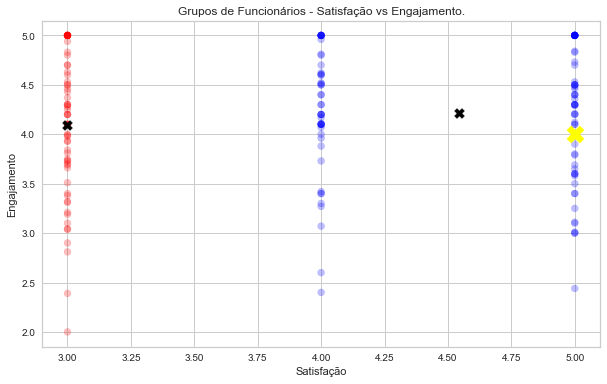

In [65]:
fig = plt.figure(figsize=(10, 6))
plt.scatter( x="EmpSatisfaction"
            ,y="EngagementSurvey"
            ,data=dataset[dataset.perfScoreSatisfaction==1],
            alpha=0.25,color = kmeans_colors)

plt.xlabel("Satisfação")
plt.ylabel("Engajamento")

plt.scatter( x=model_cluster.cluster_centers_[:,0]
            ,y=model_cluster.cluster_centers_[:,1]
            ,color="black"
            ,marker="X",s=100)

plt.scatter( x=[empSatisfaction]
            ,y=[engagementSurvey]
            ,color="yellow"
            ,marker="X",s=300)

plt.title("Grupos de Funcionários - Satisfação vs Engajamento.")
plt.show()


In [ ]:
dataset.columns

In [ ]:
dataset[['EmpSatisfaction',
       'EngagementSurvey', 'SalaryLevel', 'perfScoreSatisfaction']].head(5)

In [ ]:
d2 = dataset[['EmpSatisfaction',
       'EngagementSurvey', 'SalaryLevel', 'perfScoreSatisfaction']].head(5)
d2['perfScoreSatisfaction'] = '?'
d2.tail(5)